<a href="https://colab.research.google.com/github/ZeitDev/ISM2023w/blob/main/sanjay/phase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Necessary Modules


In [59]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import pandas as pd
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
import os
import seaborn as sns
import skimage.io
import skimage.color
from skimage.feature import hog
from skimage import exposure
from sklearn.model_selection import train_test_split

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Train Images

In [61]:
csv_data = pd.read_csv('/content/drive/MyDrive/ism_project_2023/train.csv',index_col=None)
new=csv_data.sort_values(by="name")
image_folder = '/content/drive/MyDrive/ism_project_2023/train'
train_images=[]
train_labels=[]
count=0
count_fail=0
SIZE=128
for index, row in new.iterrows():
  img_name=(row.iloc[0])+".jpg"
  img_path = os.path.join(image_folder, img_name)
  img_label=row.iloc[1]
  train_labels.append(img_label)
  if os.path.exists(img_path):
    image = skimage.io.imread(img_path)
    image=cv2.resize(image,(SIZE,SIZE))
    train_images.append(image)
    count+=1
  else:
      count_fail+=1

count,count_fail
len(train_images),len(train_labels)

(4021, 4021)

In [62]:
train_images=np.array(train_images)
train_labels=np.array(train_labels)

#### Test to load images as np.array

### Load Test Images


In [63]:
test_csv_data = pd.read_csv('/content/drive/MyDrive/ism_project_2023/test.csv',index_col=None)
new=test_csv_data.sort_values(by="name")
image_folder = '/content/drive/MyDrive/ism_project_2023/test'
test_images=[]
test_labels=[]
SIZE=128
count=0
count_fail=0
for index, row in new.iterrows():
  img_name=(row.iloc[0])+".jpg"
  img_path = os.path.join(image_folder, img_name)
  img_label=row.iloc[1]
  test_labels.append(img_label)
  if os.path.exists(img_path):
    image = skimage.io.imread(img_path)
    image=cv2.resize(image,(SIZE,SIZE))
    image=cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    test_images.append(image)
    count+=1
  else:
      count_fail+=1

count,count_fail,len(test_images),len(test_labels)

(2139, 0, 2139, 2139)

In [64]:
test_images=np.array(test_images)
test_labels=np.array(test_labels)

In [65]:
activation = 'sigmoid'

feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (SIZE, SIZE, 3)))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Flatten())


In [68]:
x = feature_extractor.output
x = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(4, activation = 'softmax')(x)

In [67]:
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12_input (InputLaye  [(None, 128, 128, 3)]     0         
 r)                                                              
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_12 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_13 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                           

In [69]:
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)
X_train=X_train/255.0
X_test=X_test/255.0
len(X_train),len(X_test),len(train_images)

(3216, 805, 4021)

In [70]:
X_for_RF = feature_extractor.predict(X_train)
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)
RF_model.fit(X_for_RF, y_train)

101/101 [==============================] - 2s 15ms/step


RandomForestClassifier(n_estimators=50, random_state=42)

In [71]:
X_test_feature=feature_extractor.predict(X_test)
predictions_rf=RF_model.predict(X_test_feature)
predictions_rf

26/26 [==============================] - 1s 24ms/step


array([2, 0, 1, 0, 0, 2, 3, 2, 2, 3, 2, 2, 2, 0, 3, 2, 0, 0, 2, 1, 2, 2,
       2, 0, 2, 3, 3, 2, 0, 0, 2, 2, 2, 1, 0, 2, 2, 2, 1, 2, 0, 1, 2, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 0, 2, 2, 1, 2, 0, 3, 2, 3, 1, 0, 2, 0, 1, 0, 2, 3, 0, 0, 0, 3,
       1, 0, 1, 2, 2, 0, 2, 2, 1, 2, 0, 2, 3, 3, 2, 2, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 2, 0, 2, 0, 1, 2, 0, 2, 2, 0, 0, 0, 0, 1, 2, 3, 0, 0, 2,
       0, 0, 0, 2, 1, 3, 0, 0, 0, 0, 0, 2, 2, 3, 3, 1, 2, 1, 2, 1, 0, 3,
       2, 2, 2, 3, 0, 0, 0, 3, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 1, 2, 0, 3, 0, 3, 1, 0, 2, 0, 2, 2, 1, 2, 2, 2, 3, 2, 2,
       0, 2, 0, 2, 2, 2, 0, 0, 3, 2, 2, 2, 0, 2, 2, 2, 3, 2, 2, 0, 0, 3,
       0, 0, 3, 0, 1, 2, 0, 2, 2, 1, 2, 2, 3, 2, 2, 2, 0, 1, 2, 2, 0, 2,
       0, 2, 0, 0, 0, 1, 0, 0, 3, 2, 2, 2, 2, 0, 1, 2, 1, 2, 2, 0, 0, 2,
       0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 1, 2, 3, 2, 2, 0, 0, 2, 2, 2, 1, 2,
       2, 2, 2, 0, 2, 0, 2, 0, 0, 1, 2, 1, 1, 1, 1,

In [72]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, predictions_rf))


Accuracy =  0.5254658385093167


In [22]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
def get_metrics(labels, predictions):
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    precision = precision_score(labels, predictions, average='macro')
    return accuracy, f1, recall, precision

In [ ]:
np.shape(X_train)

In [73]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [82]:
#Train the CNN model
history = cnn_model.fit(X_train, y_train, epochs=150, validation_data = (X_test, y_test))

Epoch 1/150
101/101 [==============================] - 6s 56ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 4.3889 - val_accuracy: 0.5391
Epoch 2/150
101/101 [==============================] - 5s 51ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 4.0947 - val_accuracy: 0.4720
Epoch 3/150
101/101 [==============================] - 5s 50ms/step - loss: 0.0066 - accuracy: 0.9988 - val_loss: 2.8699 - val_accuracy: 0.5913
Epoch 4/150
101/101 [==============================] - 5s 50ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 2.6049 - val_accuracy: 0.5453
Epoch 5/150
101/101 [==============================] - 5s 49ms/step - loss: 0.0043 - accuracy: 0.9994 - val_loss: 3.3192 - val_accuracy: 0.5627
Epoch 6/150
101/101 [==============================] - 5s 48ms/step - loss: 0.0030 - accuracy: 0.9988 - val_loss: 2.7877 - val_accuracy: 0.6087
Epoch 7/150
101/101 [==============================] - 5s 54ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 3.3787 - val_accuracy:

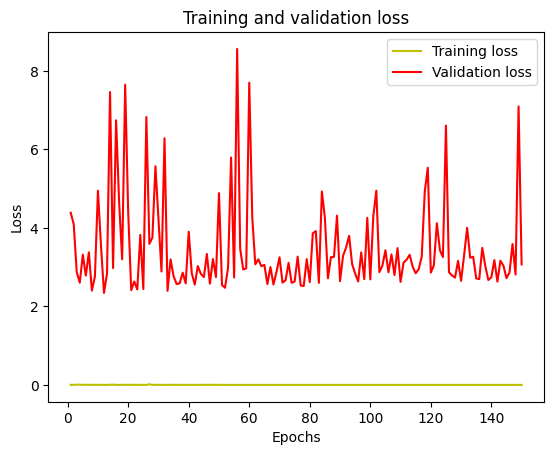

In [83]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

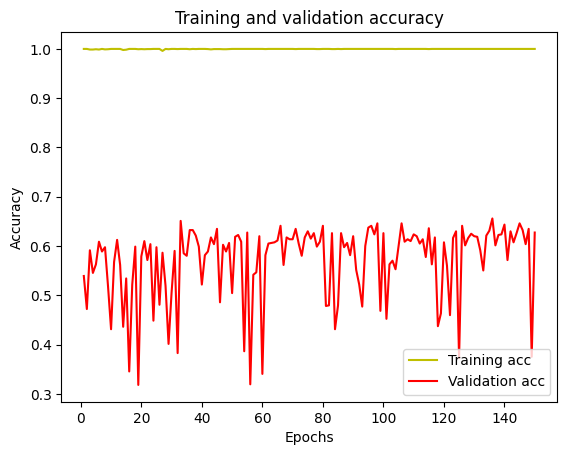

In [84]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [85]:
prediction_NN = cnn_model.predict(test_images)
prediction_NN = np.argmax(prediction_NN, axis=-1)
len(prediction_NN),len(test_labels)

67/67 [==============================] - 1s 13ms/step


(2139, 2139)